In [22]:
#conda install --channel conda-forge carterbox-torch-radon
#!pip install matplotlib
#!pip install opencv-python
#!sudo apt update && apt install -y libsm6 libxext6
#!sudo apt-get install -y libxrender-dev
#!nvidia-smi

Sat Feb  3 19:39:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      Off | 00000000:CA:00.0 Off |                    0 |
|  0%   52C    P0              22W /  60W |  12632MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from modules.operators.RadonTorch import RadonTorch
from modules.operators.Wavelet import Wavelet
import numpy as np
from modules.algorithm.ConjugateGradient import ConjugateGradient as CG
from modules.models.MetaInvNet import *
import torch
import torch_radon as tr
import os
import s3fs
from math import sqrt


device = 'cuda'

In [21]:
# connection db

S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TRAIN = "antoinedp/x_true_train"
BUCKET_X_TRUE_VAL = "antoinedp/x_true_test"

x_true_train_filenames = fs.ls(BUCKET_X_TRUE_TRAIN)[1:]
x_true_val_filenames = fs.ls(BUCKET_X_TRUE_VAL)[1:]

In [4]:
# load ground truth

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_train = import_data(x_true_train_filenames)
x_true_val = import_data(x_true_val_filenames)

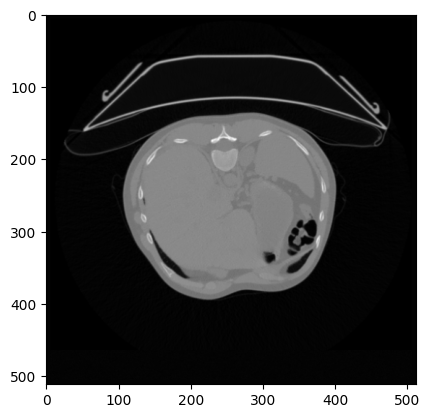

In [5]:
plt.imshow(x_true_train[5], cmap="gray")
plt.show()

In [6]:
# set projector

angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)


In [7]:
# some utils transformations
import torchvision.transforms as transforms

normalize = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())) 
])

/opt/mamba/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/mamba/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
x_true_train_tensor_unnormalized = torch.from_numpy(np.array(x_true_train)).to(dtype=torch.float32).to(device).unsqueeze(1)
x_true_val_tensor_unnormalized = torch.from_numpy(np.array(x_true_val)).to(dtype=torch.float32).to(device).unsqueeze(1)
# add poisson noise to to sinogram:
I = 3e5 

x_true_train_tensor = normalize(x_true_train_tensor_unnormalized)
x_true_val_tensor = normalize(x_true_val_tensor_unnormalized)


# to save cuda memory, we do this step in a nested manner

#true_sino_train_tensor = radon.transform(x_true_train_tensor)
#true_sino_val_tensor = radon.transform(x_true_val_tensor)

#y_train = torch.poisson(I*torch.exp(-true_sino_train_tensor/true_sino_train_tensor.max()))
#y_val = torch.poisson(I*torch.exp(-true_sino_val_tensor/true_sino_val_tensor.max()))

#noisy_sino_train_tensor = true_sino_train_tensor.max() * torch.log(I/y_train)
#noisy_sino_val_tensor = true_sino_val_tensor.max() * torch.log(I/y_val)

#filtered_noisy_sino_train_tensor=radon.radon.filter_sinogram(noisy_sino_train_tensor)
#filtered_noisy_sino_val_tensor=radon.radon.filter_sinogram(noisy_sino_val_tensor)

#noisy_x_fbp_train_tensor = radon.transposed_transform(filtered_noisy_sino_train_tensor)
#noisy_x_fbp_val_tensor = radon.transposed_transform(filtered_noisy_sino_val_tensor)


true_sino_train_tensor = radon.transform(x_true_train_tensor)
true_sino_val_tensor = radon.transform(x_true_val_tensor)

sino_train_tensor = true_sino_train_tensor.max() * torch.log(I/torch.poisson(I*torch.exp(-true_sino_train_tensor/true_sino_train_tensor.max())))
sino_val_tensor = true_sino_val_tensor.max() * torch.log(I/torch.poisson(I*torch.exp(-true_sino_val_tensor/true_sino_val_tensor.max())))

noisy_x_fbp_train_tensor = radon.transposed_transform(radon.radon.filter_sinogram(sino_train_tensor))
noisy_x_fbp_val_tensor = radon.transposed_transform(radon.radon.filter_sinogram(sino_val_tensor))

# free memory
with torch.no_grad():
    del true_sino_train_tensor
    del true_sino_val_tensor
    del x_true_train_tensor_unnormalized
    del x_true_val_tensor_unnormalized
    torch.cuda.empty_cache()


x_fbp_train_tensor = normalize(noisy_x_fbp_train_tensor)
x_fbp_val_tensor = normalize(noisy_x_fbp_val_tensor)

# free memory
with torch.no_grad():
    del noisy_x_fbp_train_tensor
    del noisy_x_fbp_val_tensor
    torch.cuda.empty_cache()



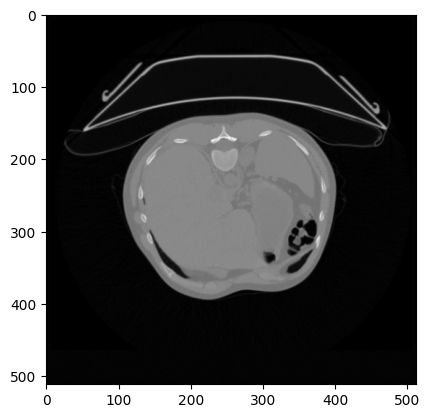

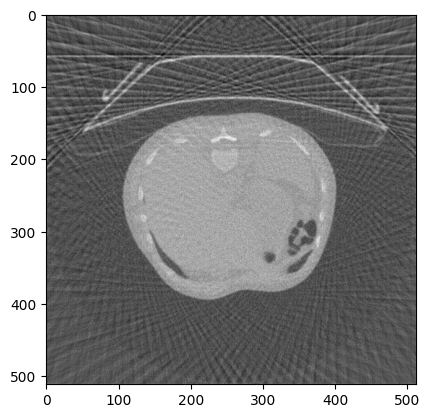

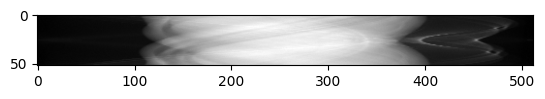

In [9]:
from matplotlib import pyplot as plt
plt.imshow(x_true_train_tensor[5].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_train_tensor[5].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(sino_train_tensor[5].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

In [10]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sino, x_fbp, x_true):
        super(CustomDataset, self).__init__()
        self.sino = sino
        self.x_fbp = x_fbp
        self.x_true = x_true

    def __getitem__(self, index):
        return self.sino[index,], self.x_fbp[index,], self.x_true[index,]

    def __len__(self):
        return len(self.sino)


dataloader_train = DataLoader(CustomDataset(sino_train_tensor, x_fbp_train_tensor, x_true_train_tensor), batch_size=1, shuffle=True, drop_last=True)
dataloader_val = DataLoader(CustomDataset(sino_val_tensor, x_fbp_val_tensor, x_true_val_tensor), batch_size=1, shuffle=True, drop_last=True)

In [14]:
import json
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (sino, X, y) in enumerate(dataloader):
        sino = sino.to(device)
        X = X.to(device)
        y = y.to(device)
        
        # Compute prediction and loss
        pred = model(sino, X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        #torch.nn.utils.clip_grad.clip_grad_value_(model.parameters(), clip_value=1e-1)
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")

    scheduler.step()
    



def test_loop(dataloader, model, loss_fn, device, set = "Test"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for sino, X, y in dataloader:
            sino = sino.to(device)
            X = X.to(device)
            y = y.to(device)

            pred = model(sino, X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"\n{set} set: Avg loss: {test_loss: >8f} \n")
    return test_loss


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, epochs, device, start_epoch = 0, errors = {"train" : [], "val":[]}):
    for t in range(start_epoch, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
        
        torch.save({'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss_fn}, 
        	'./metainvnet_3e5_tv_0_005_200_l2_loss.pth')
        
        loss_train = test_loop(train_dataloader, model, loss_fn, device, set = "Training")
        loss_val = test_loop(test_dataloader, model, loss_fn, device)
        
        errors["train"].append(loss_train)
        errors["val"].append(loss_val)

        with open('./data/errors/metainvnet_3e5_tv_0_005_200_l2_loss', 'w') as json_file:
            json.dump(errors, json_file)

In [15]:
from torch.optim import lr_scheduler, SGD, Adam
from modules.models.MetaInvNet import *


def ssim_loss(img1, img2, size=11,sigma = 1.5, cs_map=False):
        
    img1 = img1.unsqueeze(0)
    img2 = img2.unsqueeze(0)
    L = torch.max(torch.tensor([torch.max(img1) - torch.min(img1),torch.max(img2) - torch.min(img2)]))


    window = fspecial_gauss(size, sigma)
    window = torch.from_numpy(window.copy()).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()
    window = torch.nn.Parameter(data=window, requires_grad=False)
    K1 = 0.001
    K2 = 0.03
    #L = 2.0
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = F.conv2d(img1,window)
    mu2 = F.conv2d(img2,window)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window )- mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window )- mu2_sq
    sigma12 = F.conv2d(img1 * img2, window )- mu1_mu2
    
    if cs_map:
        return (((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))
    else:
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
        ssim = torch.clamp(ssim,min=0.0,max=1.0)
        return ssim.mean()

def l2loss_mean(x,y):
    assert x.size() == y.size()
    loss = torch.sum((x-y) ** 2)
    return loss

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def loss_fun(db, sp):
    layer = len(db)
    loss = 0.0
    for ii in range(0, layer):
        loss += l2loss_mean(sp, db[ii]) * 1.1**ii
    
    for ii in range(0, layer):
        for jj in range(sp.shape[1]):
            img1=sp[jj,...]
            img2=db[ii][jj,...]

            ssim_value=1-ssim_loss(img1, img2,size=11,sigma = 1.5)
            loss += ssim_value*100.0

    return loss

from math import sqrt

class TVTorch:
    
    def transform(self, x):
        
        x1 = (x - torch.roll(x, shifts=(0, 1), dims=(2, 3))) 
        x2 = (x - torch.roll(x, shifts=(0, -1), dims=(2, 3))) 
        x3 = (x - torch.roll(x, shifts=(1, 0), dims=(2, 3))) 
        x4 = (x - torch.roll(x, shifts=(-1, 0), dims=(2, 3))) 
        
        x5 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(1, -1), dims=(2, 3))) 
        x6 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(-1, 1), dims=(2, 3))) 
        x7 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(1, 1), dims=(2, 3))) 
        x8 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(-1, -1), dims=(2, 3))) 
        
        return torch.cat((x1, x2, x3, x4, x5, x6, x7, x8), dim=1)
    
    def transposed_transform(self, x):
        
        x1 = (x[:,0:1,:,:] - torch.roll(x[:,0:1,:,:], shifts=(0, -1), dims=(2, 3)))
        x2 = (x[:,1:2,:,:] - torch.roll(x[:,1:2,:,:], shifts=(0, 1), dims=(2, 3)))
        x3 = (x[:,2:3,:,:] - torch.roll(x[:,2:3,:,:], shifts=(-1, 0), dims=(2, 3)))
        x4 = (x[:,3:4,:,:] - torch.roll(x[:,3:4,:,:], shifts=(1, 0), dims=(2, 3)))
        
        x5 = (1/sqrt(2)) * (x[:,4:5,:,:] - torch.roll(x[:,4:5,:,:], shifts=(-1, 1), dims=(2, 3)))
        x6 = (1/sqrt(2)) * (x[:,5:6,:,:] - torch.roll(x[:,5:6,:,:], shifts=(1, -1), dims=(2, 3)))
        x7 = (1/sqrt(2)) * (x[:,6:7,:,:] - torch.roll(x[:,6:7,:,:], shifts=(-1, -1), dims=(2, 3)))
        x8 = (1/sqrt(2)) * (x[:,7:8,:,:] - torch.roll(x[:,7:8,:,:], shifts=(1, 1), dims=(2, 3)))
        
        return x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8


In [ ]:

def loss_fun(pred, y):
    layer = len(pred)
    loss = 0.0
    l2loss = torch.nn.MSELoss()
    for l in range(layer):
        loss += l2loss(pred[l], y) * (1.1**l)
    return loss
        

# train 
import math
def lr_lambda(epoch):
    return 1 #math.exp(-0.05*epoch)

wl = TVTorch()
epochs = 10
start_epoch = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelMetaInv = MetaInvNetL(10, radon, wl).to(device)
optimizer = Adam(modelMetaInv.parameters(), lr=1e-3)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss = loss_fun

train(model=modelMetaInv,
      train_dataloader=dataloader_train,
      test_dataloader=dataloader_val,
      loss_fn=loss,
      optimizer=optimizer,
      scheduler=scheduler,
      epochs=epochs,
      device=device,
      start_epoch=start_epoch)

Epoch 1
-------------------------------
loss: 0.005383  [    1 /  2000]
loss: 0.002211  [  101 /  2000]
loss: 0.002795  [  201 /  2000]
loss: 0.004014  [  301 /  2000]
loss: 0.001870  [  401 /  2000]
loss: 0.002660  [  501 /  2000]
loss: 0.002530  [  601 /  2000]
loss: 0.003582  [  701 /  2000]
loss: 0.002867  [  801 /  2000]
loss: 0.003101  [  901 /  2000]
loss: 0.003294  [ 1001 /  2000]
loss: 0.002801  [ 1101 /  2000]
loss: 0.002371  [ 1201 /  2000]
loss: 0.002375  [ 1301 /  2000]
loss: 0.002193  [ 1401 /  2000]
loss: 0.002279  [ 1501 /  2000]
loss: 0.002622  [ 1601 /  2000]
loss: 0.002059  [ 1701 /  2000]
loss: 0.002372  [ 1801 /  2000]
loss: 0.002153  [ 1901 /  2000]

Training set: Avg loss: 0.002103 


Test set: Avg loss: 0.002151 

Epoch 2
-------------------------------
loss: 0.002192  [    1 /  2000]
loss: 0.002339  [  101 /  2000]
loss: 0.002041  [  201 /  2000]
loss: 0.002218  [  301 /  2000]
loss: 0.001979  [  401 /  2000]
loss: 0.001576  [  501 /  2000]
loss: 0.002448  [  6

In [ ]:
def hqscg(Y, xk_L, zk, lam_over_gamma , gamma, projection, wavelet):

    for i in range(25):        
        xkp1_0 = xk_L

        AtY = projection.transposed_transform(Y)
        gammaWtzk = gamma * wavelet.transposed_transform(zk)
        AtAxkp1_0 = projection.transposed_transform(projection.transform(xkp1_0))
        Wtwxkp1_0 = gamma * wavelet.transposed_transform(wavelet.transform(xkp1_0))
        
        residual =  (AtY + gammaWtzk) - (AtAxkp1_0 + Wtwxkp1_0)

        # conjugate gradient
        rk = residual
        pk = residual
        xk = xkp1_0
        for i in range(25):
            
            rkTrk = torch.sum(rk**2,dim=(1,2,3))
            #compute Gpk where G = (ATA + lambda*WtW) (save results for future operations)
            Gpk = projection.transposed_transform(projection.transform(pk)) + gamma * wavelet.transposed_transform(wavelet.transform(pk))
            #compute pkGpk
            pkGpk = torch.sum(pk * Gpk, dim=(1,2,3))
    
            alphak = rkTrk/pkGpk
            alphak = alphak.view(-1,1,1,1)
            xk = xk + alphak*pk
            rk = rk - alphak*Gpk
            betak = torch.sum(rk**2,dim=(1,2,3)) / rkTrk
            betak = betak.view(-1,1,1,1)
            pk = rk + betak * pk

        xkp1_L = xk
        
        # soft tresholding
        Wxkp1_L = wavelet.transform(xkp1_L)
        zkp1 = F.relu(Wxkp1_L-lam_over_gamma) - F.relu(-Wxkp1_L-lam_over_gamma)

        xk_L=xkp1_L
        zk=zkp1

    disp =xk_L.clone().squeeze(0).squeeze(0).to('cpu').numpy()
    plt.imshow(disp, cmap="gray")
    plt.show()
    return disp

wl = Wavelet()
sino, img_x, img_y = next(iter(dataloader_val))
tv = TVTorch()

#for sino, img_x, img_y in dataloader_val: 
#    x0 = img_x
#    z0 = tv.transform(x0).cuda()
#    val = hqscg(sino, x0, z0, 0.01, 100, radon, tv)

# grid search             
for sino, img_x, img_y in dataloader_val: 
    I = [0.005, 0.01, 0.05]#[10**(-i) for i in range(5, -5, -1)]
    J = [200, 300, 400, 500]#[10**(-i) for i in range(5, -5, -1)]
    Is = []
    Js = []
    vals = []
    truth = img_y.clone().squeeze(0).squeeze(0).to('cpu').numpy()
    for i in I:
        for j in J:
            x0 = img_x
            z0 = tv.transform(x0).cuda()
            val = hqscg(sino, x0, z0, i, j, radon, tv)
            norm = np.sum(np.abs(val - truth))
            Is.append(i)
            Js.append(j)
            vals.append(norm.item())
            print(i,j)
    print('---------------')
    min_index = vals.index(min(vals))
    print(Is[min_index], Js[min_index])
    all.append((Is[min_index], Js[min_index]))
    print('---------------')


: 

In [11]:
wl = Wavelet()


In [ ]:
# to load model
#modelMetaInv = MetaInvNetL(10, radon, wl).to(device)
#checkpoint = torch.load('./metainvnet_3e5_0_0035_300.pth')
#modelMetaInv.load_state_dict(checkpoint['model_state_dict'])
#modelMetaInv.eval()

: 

tensor(3.1188e-05, device='cuda:0', grad_fn=<AddBackward0>)


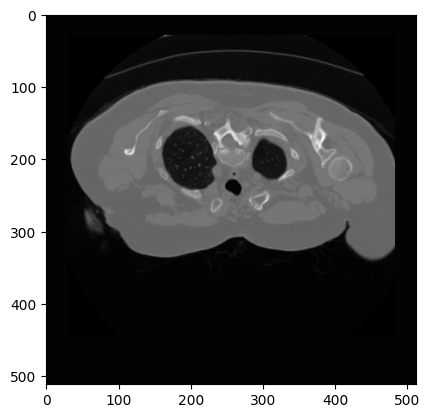

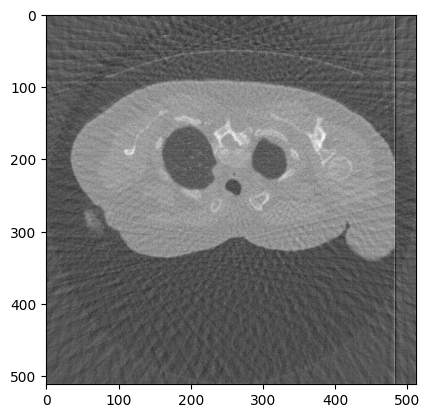

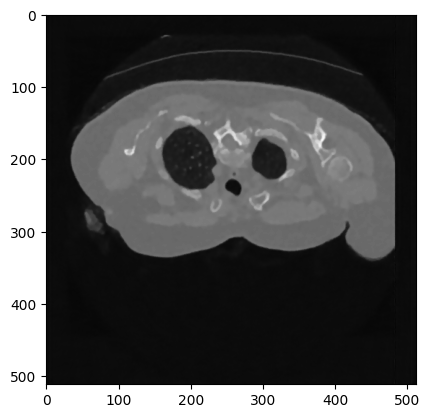

In [44]:
sino, img_x, img_y = next(iter(dataloader_val))

z = modelMetaInv(sino, img_x)

print(loss_fun(z[10], img_y))
prediction=z[10].detach().to('cpu').squeeze(0).squeeze(0).numpy()

truth=img_y.to('cpu').squeeze(0).squeeze(0).numpy()

plt.imshow(truth, cmap = 'gray')
plt.show()

plt.imshow(img_x.to('cpu').squeeze(0).squeeze(0).numpy(), cmap = 'gray')
plt.show()


plt.imshow(prediction, cmap = 'gray')
plt.show()



In [28]:
def psnr(original, reconstructed):

    # normalizing to have pixels between 0 and 1 to compute the peak signal to noise ratio
    noriginal = (original - np.min(original)) / (np.max(original) - np.min(original))
    nreconstructed = (reconstructed - np.min(reconstructed)) / (np.max(reconstructed) - np.min(reconstructed))

    # compute Mean Squared Error (MSE)
    mse = np.mean((noriginal - nreconstructed) ** 2)

    # compute PSNR in decibels
    if mse == 0:
        return float('inf')  # PSNR is infinite if the images are identical
    else:
        psnr_value = 10 * np.log10((1 ** 2) / mse) # 1 being the max pixel value / range of pixel values
        return psnr_value

print(psnr(truth, prediction))


35.41344644041899
